In [1]:
%load_ext autoreload
import time
from importlib import reload

""" *********************************************************************************************************************************** """
# MONGODB
from pymongo import MongoClient
from bson import  ObjectId
#Ploting
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Data and processing
import datetime
import numpy as np
import pandas as pd
# Printing
import pprint
# parallel
import os
""" *********************************************************************************************************************************** """
import sys
sys.path.append('git/PRIM/source/')
sys.path.append('git/PRIM/scripts/')

import Trips
import DataProcessing
import Plotting
import TripsProcessing
import OsmProcessing
import speed_matrix 
import CustomUtils
import osmMerger
from speed_matrix import SpeedMatrix
from affect_road_to_point_para import get_north_azimut
""" *********************************************************************************************************************************** """
from mongoConnection import client , coyoteData ,osmWays
from IPython.display import Latex
%aimport pandas , numpy , matplotlib, seaborn, os, sys, ipyparallel, pprint, folium, datetime
sns.set()

In [12]:
def plotNbMissingSegmentData(data,seqLength):

    plt.plot(data.isna().sum().values/len(data))
    plt.plot([ x/len(data) if y.date().weekday()>=5 else None for x,y in zip(data.isna().sum(),data.isna().sum().index)],linewidth=2)
    for x in range(0,len(data.columns),seqLength):
        plt.axvline(x,linestyle=':',color='red') 
    plt.legend(['weekdays','weekends','days'])
    plt.ylabel('percentage of segments with no data')
    plt.xticks(range(0,len(data.isna().sum().index),6),data.isna().sum().index[0::6], rotation='vertical');

In [3]:
def plotCorrelationCoefs(data ,seqLength,xmpID=0):
    plt.figure(figsize=(18,4))
    xmp=np.corrcoef(data.T.values)[xmpID]
    plt.plot(xmp,'-+')
    for x in range(0,len(xmp),seqLength):
        plt.axvline(x,linestyle=':',color='red',alpha=0.5) 
    for x in range(xmpID%seqLength,len(xmp),seqLength):
        plt.axvline(x,linestyle='--',color='green',alpha=0.5) 

In [17]:
rawUpdatedSpeed=pd.read_pickle("rawUpdatedSpeed1419.pckl")
updatedSpeed=pd.read_pickle("updatedSpeed1419.pckl")
meanUpdatedSpeed=pd.read_pickle("updatedSpeedWithHistoricalValues1419.pckl")
speeds = pd.read_pickle('/home/dsi/mbouchouia/code/speeds1419.pckl')
speeds80 = speeds.groupby('matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns)))
counts = pd.read_pickle('/home/dsi/mbouchouia/code/counts1419.pckl')

In [16]:
rawUpdatedSpeed.columns.size

260

In [5]:
dts=pd.Series(speeds.columns)
seqLength=dts.groupby([dts.dt.day,dts.dt.month]).size().iloc[0]

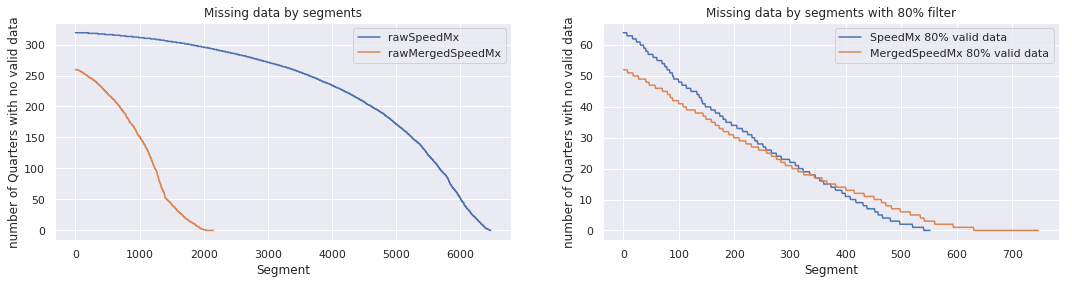

In [6]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.plot(speeds.isna().sum(axis=1).sort_values(ascending=False).values)
plt.plot(rawUpdatedSpeed.isna().sum(axis=1).sort_values(ascending=False).values)
plt.legend(['rawSpeedMx','rawMergedSpeedMx'])
plt.ylabel("number of Quarters with no valid data")
plt.xlabel("Segment")
plt.title('Missing data by segments')

plt.subplot(1,2,2)
plt.plot(speeds.groupby('matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns))).isna().sum(axis=1).sort_values(ascending=False).values)
plt.plot(updatedSpeed.isna().sum(axis=1).sort_values(ascending=False).values)
plt.legend(['SpeedMx 80% valid data','MergedSpeedMx 80% valid data'])
plt.ylabel("number of Quarters with no valid data")
plt.title('Missing data by segments with 80% filter')
plt.xlabel("Segment")

plt.show()

In [7]:
"""
segs = OsmProcessing.getSegments(osmWays)
segs= OsmProcessing.setOneWay(segs)
fmap=Plotting.getFoliumMap()
layer=Plotting.plotRoads(segs.loc[segs.index.isin(np.fromiter([int(x[:-2]) for x in speeds80.index.values],dtype=int))],fmap=fmap)
Plotting.stackHistotyLayers([layer],fmap)
fmap.save('NewMap.html')"""

"\nsegs = OsmProcessing.getSegments(osmWays)\nsegs= OsmProcessing.setOneWay(segs)\nfmap=Plotting.getFoliumMap()\nlayer=Plotting.plotRoads(segs.loc[segs.index.isin(np.fromiter([int(x[:-2]) for x in speeds80.index.values],dtype=int))],fmap=fmap)\nPlotting.stackHistotyLayers([layer],fmap)\nfmap.save('NewMap.html')"

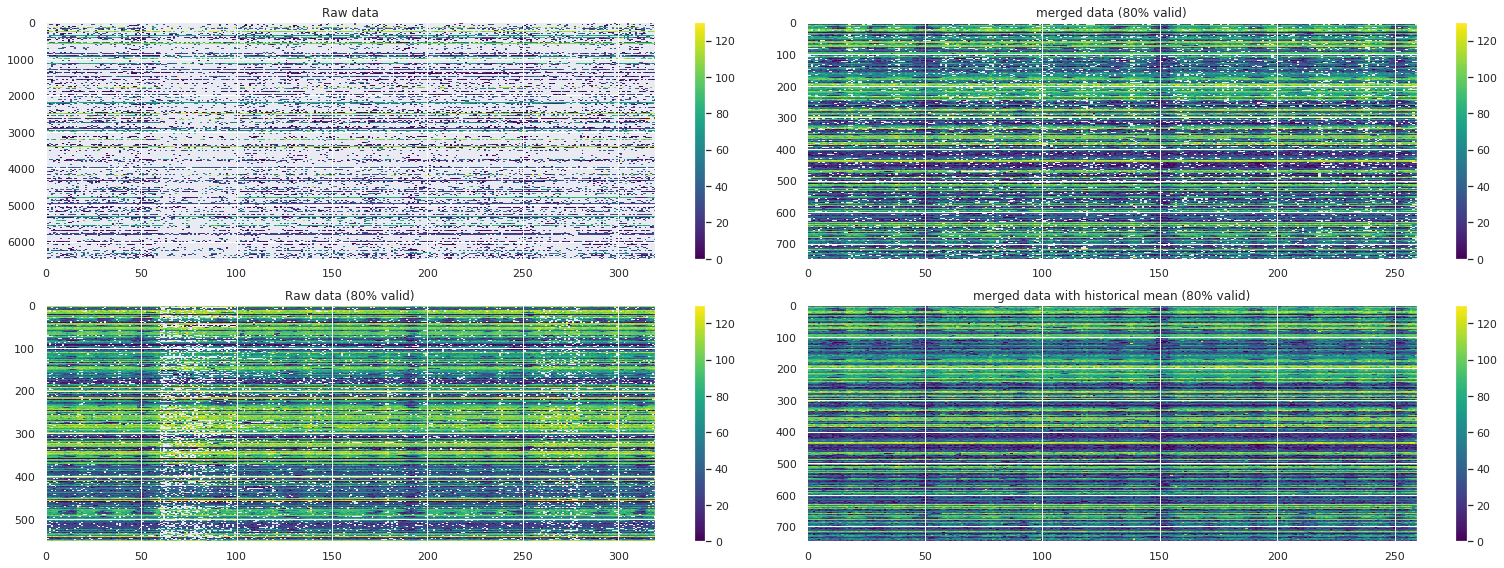

In [8]:
fig=plt.figure(figsize=(22,8))
plt.subplot(2,2,1,title = 'Raw data')
plt.imshow(speeds,aspect='auto',cmap=plt.cm.viridis)

plt.colorbar()
plt.subplot(2,2,3,title = 'Raw data (80% valid)')
plt.imshow(speeds.groupby('matching_road').mean().dropna(thresh = int(0.8*len(speeds.columns))),aspect='auto',cmap=plt.cm.viridis)
plt.colorbar()

plt.subplot(2,2,2,title = 'merged data (80% valid)')
plt.imshow(updatedSpeed.values,aspect='auto',cmap=plt.cm.viridis)
plt.colorbar()
plt.subplot(2,2,4,title = 'merged data with historical mean (80% valid)')
plt.imshow(meanUpdatedSpeed.values,aspect='auto',cmap=plt.cm.viridis)
plt.colorbar()
plt.tight_layout()
plt.show()

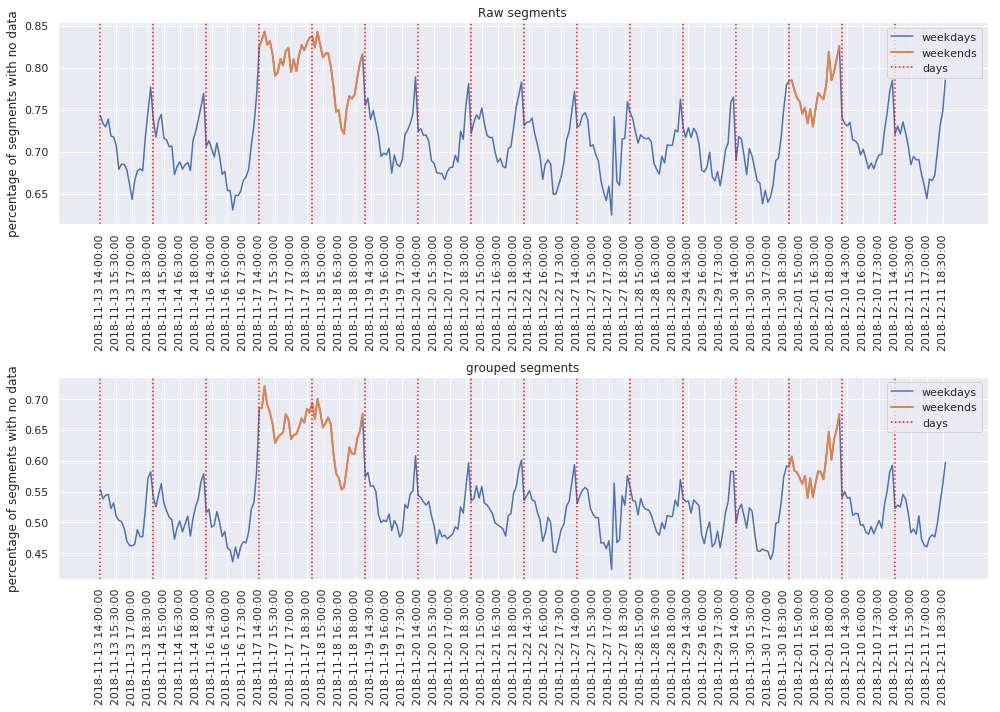

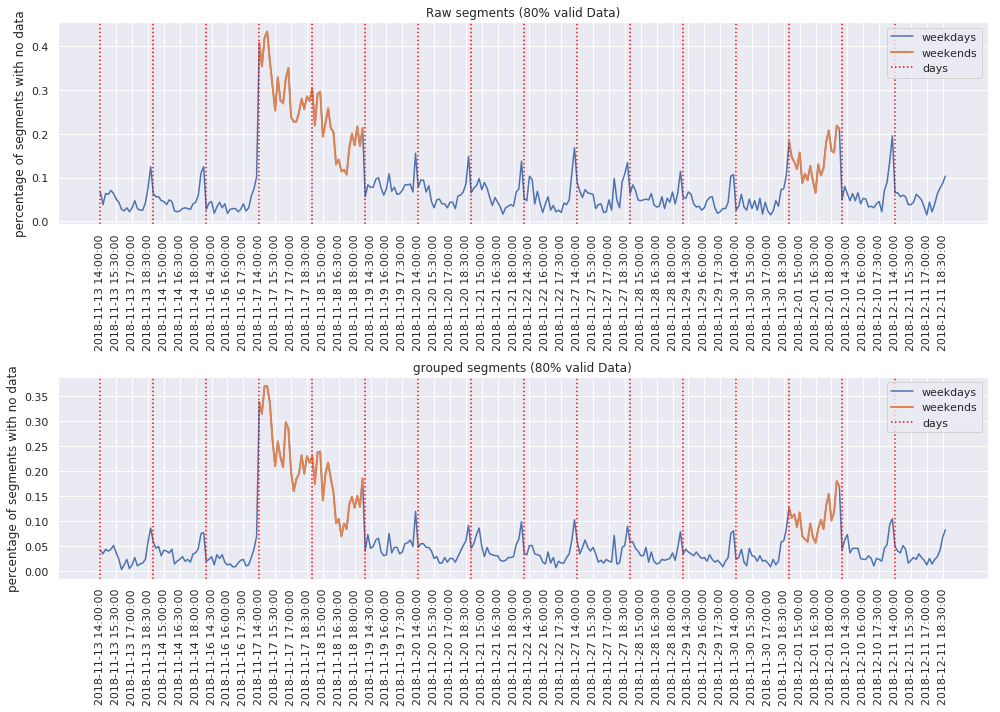

In [18]:
plt.figure(figsize= (14,10))
plt.subplot(2,1,1)
plotNbMissingSegmentData(speeds,seqLength)
plt.title('Raw segments')
plt.subplot(2,1,2)
plotNbMissingSegmentData(rawUpdatedSpeed,seqLength)
plt.title('grouped segments')
plt.tight_layout()
plt.savefig("imgs/percentage of segments with no data raw.png",dpi=1200)
plt.figure(figsize= (14,10))

plt.subplot(2,1,1)
plotNbMissingSegmentData(speeds80,seqLength)
plt.title('Raw segments (80% valid Data)')
plt.subplot(2,1,2)
plotNbMissingSegmentData(updatedSpeed,seqLength)
plt.title('Grouped segments (80% valid Data)')
plt.tight_layout()
plt.savefig("imgs/percentage of segments with no data grouped.png",dpi=1200)

plt.show()

Text(0, 0.5, 'number of points')

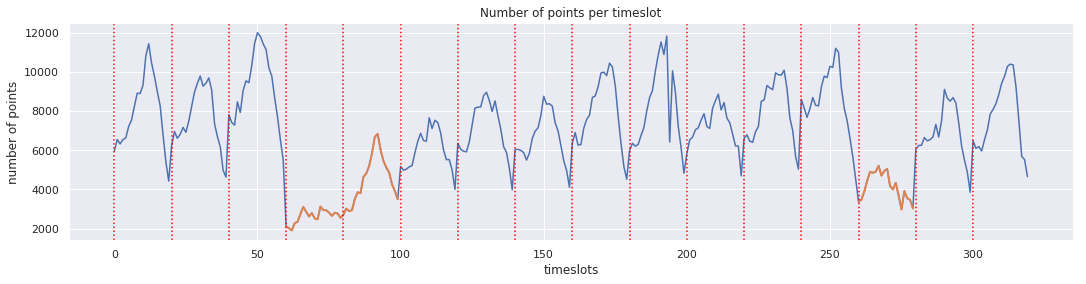

In [10]:
plt.figure(figsize=(18,4))
plt.plot(counts.sum().values)
plt.plot([ x if y.date().weekday()>=5 else None for x,y in zip(counts.sum(),counts.sum().index)],linewidth=2)
for x in range(0,len(counts.columns),seqLength):
    plt.axvline(x,linestyle=':',color='red')
plt.title("Number of points per timeslot")
plt.xlabel('timeslots')
plt.ylabel("number of points")

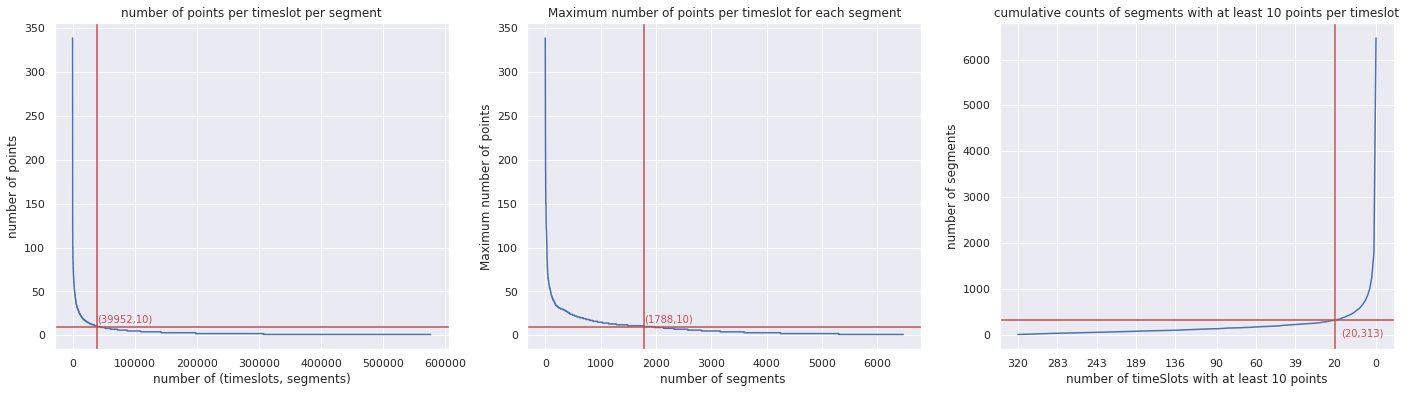

In [11]:
plt.figure(figsize=(24,6))
plt.subplot(1,3,1)


sorted_counts=pd.Series(counts.values.flatten()).sort_values(ascending=False).values

ylim=10
xlim=np.where(sorted_counts==ylim)[0][0]

plt.plot(sorted_counts)
plt.annotate("({},{})".format(xlim,ylim),(xlim+5,ylim+5),color='r')

plt.axvline(xlim,c='r')
plt.axhline(ylim,c='r')
plt.title("number of points per timeslot per segment")
plt.xlabel("number of (timeslots, segments)")
plt.ylabel("number of points")

plt.subplot(1,3,2)


sorted_counts=counts.max(axis=1).sort_values(ascending=False).values
ylim=10
xlim=np.where(sorted_counts==ylim)[0][0]
plt.plot(sorted_counts)
plt.annotate("({},{})".format(xlim,ylim),(xlim+5,ylim+5),color='r')
plt.axvline(xlim,c='r')
plt.axhline(ylim,c='r')
plt.ylabel("Maximum number of points")
plt.xlabel("number of segments ")
plt.title("Maximum number of points per timeslot for each segment")

plt.subplot(1,3,3)
countSup10=(counts.fillna(0)>10).sum(axis=1).value_counts().sort_index(ascending=False).cumsum()
plt.plot(countSup10.values)
plt.xticks(np.r_[0:len(countSup10.index.values)-1:10j].astype(int),labels=countSup10.index.values[np.r_[0:len(countSup10.index.values)-1:10j].astype(int)]);
xlim=countSup10.index.get_loc(20)
ylim=countSup10.loc[20]
plt.annotate("({},{})".format(20,ylim),(xlim+3,ylim-355),color='r')
plt.axvline(xlim,c='r')
plt.axhline(ylim,c='r')

plt.ylabel("number of segments")
plt.xlabel("number of timeSlots with at least 10 points")
plt.title("cumulative counts of segments with at least 10 points per timeslot");


In [12]:
"""for i in range(seqLength*7,seqLength*8,1):
    plotCorrelationCoefs(meanUpdatedSpeed,seqLength,i)
    plt.axvline(i,c='r')"""

"for i in range(seqLength*7,seqLength*8,1):\n    plotCorrelationCoefs(meanUpdatedSpeed,seqLength,i)\n    plt.axvline(i,c='r')"

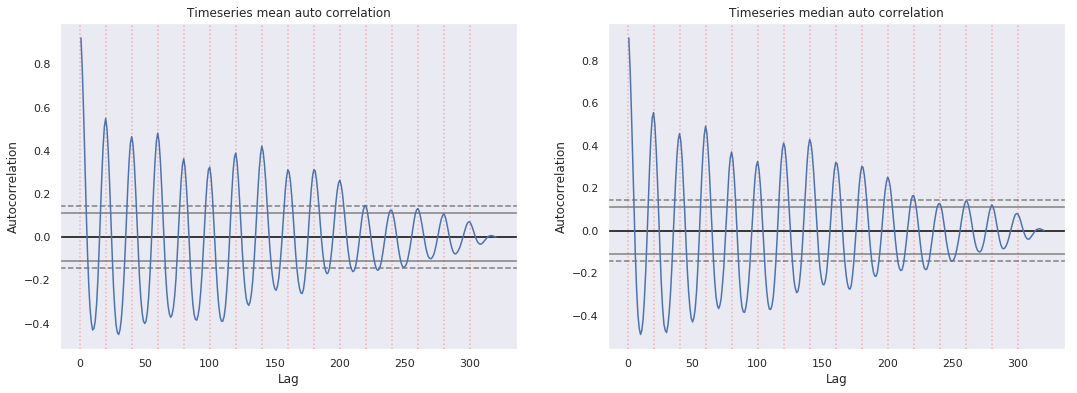

Equation


<IPython.core.display.Latex object>

In [13]:
plt.figure(figsize=(18,6))
pd.plotting.autocorrelation_plot(meanUpdatedSpeed.describe().loc['mean'],ax=plt.subplot(1,2,1))
for x in range(0,len(meanUpdatedSpeed.T),seqLength):
    plt.axvline(x,linestyle=':',color='red',alpha=0.25) 
plt.title('Timeseries mean auto correlation')
pd.plotting.autocorrelation_plot(meanUpdatedSpeed.describe().loc['50%'],ax=plt.subplot(1,2,2))
for x in range(0,len(meanUpdatedSpeed.T),seqLength):
    plt.axvline(x,linestyle=':',color='red',alpha=0.25) 
plt.title('Timeseries median auto correlation')
plt.show()

print("Equation")
Latex(r'$\Large {\hat {R}}(k)={\frac{1}{n\sigma ^{2}}}\sum _{t=1}^{n-k}(X_{t}-\mu )(X_{t+k}-\mu )$')

Text(0.5, 1.0, 'Histogram correlation coefs of rows (segments)')

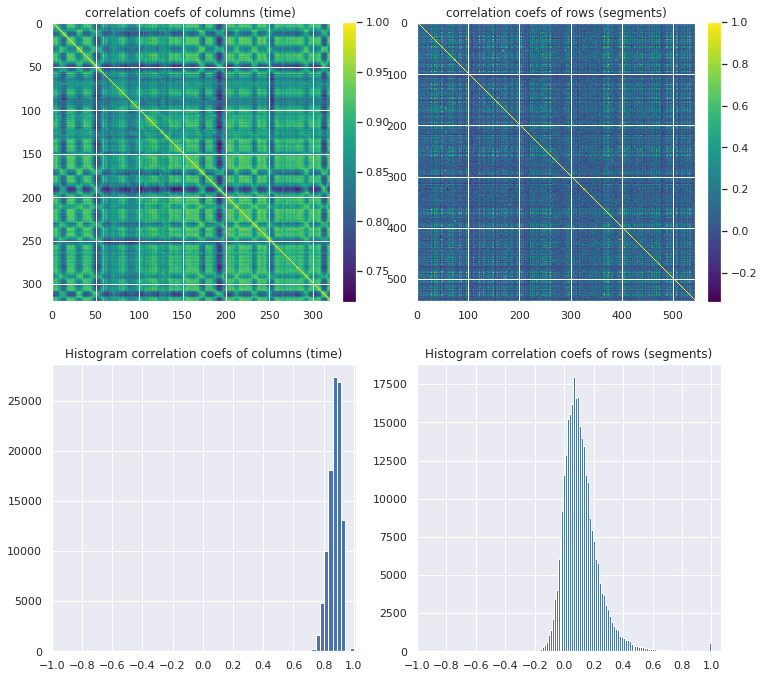

In [14]:
plt.figure(figsize=(12,18))
plt.subplot(3,2,1)
plt.imshow(np.corrcoef(meanUpdatedSpeed.T.values),cmap=plt.cm.viridis)
plt.title("correlation coefs of columns (time)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(3,2,2)
plt.imshow(np.corrcoef(meanUpdatedSpeed.values),cmap=plt.cm.viridis)
plt.title("correlation coefs of rows (segments)")
plt.colorbar( fraction=0.046, pad=0.04)
plt.subplot(3,2,3)
roundedCoefs=np.corrcoef(meanUpdatedSpeed.T.values).round(decimals=3).flatten()

plt.hist(roundedCoefs,bins=10)
plt.xticks(np.arange(-1,1.1,0.2))
plt.title("Histogram correlation coefs of columns (time)")

plt.subplot(3,2,4)
roundedCoefs=np.corrcoef(meanUpdatedSpeed.values).round(decimals=3).flatten()
plt.hist(roundedCoefs,bins=100)
plt.xticks(np.arange(-1,1.1,0.2))
plt.title("Histogram correlation coefs of rows (segments)")

# pd.plotting.autocorrelation_plot(meanUpdatedSpeed.T,plt.subplot(3,2,5))
# for x in range(0,len(meanUpdatedSpeed.T),12):
#     plt.axvline(x,linestyle=':',color='red',alpha=0.25) 
# plt.title("autocorrelation of columns (time)")


# pd.plotting.autocorrelation_plot(meanUpdatedSpeed,plt.subplot(3,2,6))
# plt.title("autocorrelation of rows (segments)")
# plt.tight_layout()